In [1]:
import re

import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
comments = pd.read_csv('Comments.csv')

# Sample sentiment analysis
1. Using prebuilt packages
    - Data cleaning and exploration
    - Vader and Textblob  </br>
2. Training own classifier
    - Preprocessing
    - Naive Bayes

## __1.__ __Using prebuilt packages__

 - ### __Data cleaning and exploration__

In [3]:
sample = comments.Reply.iloc[10]
sample

'Why dont they just fix their paint issues than cashing in on people?'

In [4]:
re.sub(r'\(?http\S+', '', sample)

'Why dont they just fix their paint issues than cashing in on people?'

Getting rid of \n, \t... etc characters that does not help with prediction but might link 2 words together and make them indistinguishable from one another

In [5]:
sample = comments.Reply.iloc[9]
sample

"Why don't they just invest in paint shop and QC so that people don't need to wrap the cars ?\r\n\r\nEdit: INB4 I get jumped on by downvoters - you don't see buyers wrapping their new Audis or BMWs, right ? d;o)"

In [6]:
word_tokenized = nltk.word_tokenize(sample)
word_tokenized

['Why',
 'do',
 "n't",
 'they',
 'just',
 'invest',
 'in',
 'paint',
 'shop',
 'and',
 'QC',
 'so',
 'that',
 'people',
 'do',
 "n't",
 'need',
 'to',
 'wrap',
 'the',
 'cars',
 '?',
 'Edit',
 ':',
 'INB4',
 'I',
 'get',
 'jumped',
 'on',
 'by',
 'downvoters',
 '-',
 'you',
 'do',
 "n't",
 'see',
 'buyers',
 'wrapping',
 'their',
 'new',
 'Audis',
 'or',
 'BMWs',
 ',',
 'right',
 '?',
 'd',
 ';',
 'o',
 ')']

In [7]:
' '.join(word_tokenized)

"Why do n't they just invest in paint shop and QC so that people do n't need to wrap the cars ? Edit : INB4 I get jumped on by downvoters - you do n't see buyers wrapping their new Audis or BMWs , right ? d ; o )"

#### Bigrams

In [8]:
sample = ['more', 'is', 'said', 'than', 'done', 'is', 'said', 'than']

In [9]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# only bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('is', 'said'), ('said', 'than')]


Let's try it on first 10000 rows of our text

In [10]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [11]:
all_text = nltk.word_tokenize(all_text)

In [12]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('Pikes', 'Peak'), ('overheat', 'protection'), ('cabin', 'overheat'), ('Giga', 'Berlin'), ('chrome', 'delete'), ('lead', 'acid'), ('stainless', 'steel'), ('Long', 'Range'), ('gon', 'na'), ('wan', 'na')]


#### Wordcloud

In [13]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [14]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

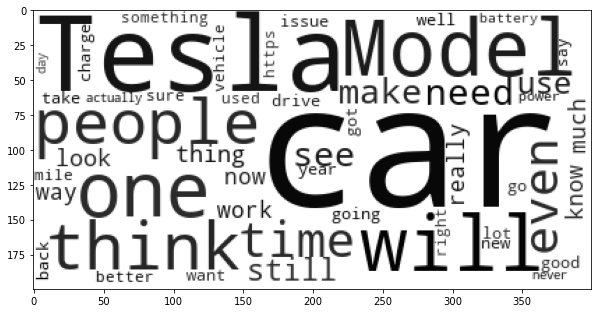

In [15]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

- ### __Vader and Textblob__

Vader package first

In [16]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#FIRST, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


We can add sentiment scores to words manually if we want

In [17]:
new_words = {
    'hello': -1000,
}

sid.lexicon.update(new_words)

In [18]:
sid.polarity_scores('hello there')

{'neg': 0.999, 'neu': 0.001, 'pos': 0.0, 'compound': -1.0}

In [19]:
#As this is for demonstration purposes only - instead of doing the scoring over 200,000+ rows, we will use a subset
df = comments[comments.Key<101]
df.shape

(6267, 4)

In [20]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
df[['neg','neu','pos','compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
df.head(3)

,Reply,Time,Upvote,Key,neg,neu,pos,compound
0,> * New buyers can order wraps for their cars ...,2020-08-06 22:42:19,779,1,0.000,0.950,0.050,0.4019
1,I hope their wraps are better than their paint .,2020-08-06 22:37:17,408,1,0.000,0.508,0.492,0.7003
2,I ’ d leave it to the experts…,2020-08-06 23:04:55,823,1,0.231,0.769,0.000,-0.0516


Textblob package now

In [23]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [24]:
nltk.download('movie_reviews')
tba('My life is a frictionless slide downhill').sentiment

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakya\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [25]:
#As this is for demonstration purposes only - we will only use a subset
df = comments[comments.Key<101]

In [26]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
df[['Classification','positive','negative']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

d:\sentiment-analysis\venv\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [28]:
df.head(3)

,Reply,Time,Upvote,Key,Classification,positive,negative
0,> * New buyers can order wraps for their cars ...,2020-08-06 22:42:19,779,1,pos,0.999638,0.000362
1,I hope their wraps are better than their paint .,2020-08-06 22:37:17,408,1,pos,0.581465,0.418535
2,I ’ d leave it to the experts…,2020-08-06 23:04:55,823,1,pos,0.572745,0.427255


## __2.__ __Training your own classifier__

 - ### __Preprocessing__

In [29]:
data = pd.read_csv('train.csv')

In [30]:
data.head(1)

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral


In [31]:
data.dropna(subset=['text'], inplace=True)

Remove punctuation

In [32]:
data.text = data.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

Remove stopwords

In [33]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
data.text = data.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

Remove links

In [34]:
data.text = data.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

Stemming and Lemmatization

In [35]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

In [36]:
text = nltk.word_tokenize('women run running runs ran')
stemmed = [porter_stemmer.stem(word) for word in text]
stemmed

['women', 'run', 'run', 'run', 'ran']

In [37]:
lemmatizer = nltk.WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in text]
lemmatized

['woman', 'run', 'running', 'run', 'ran']

In [38]:
data.text = data.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
        ) )

 - ### __Training a naive bayes sentiment classifier__

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

We use CountVectorizer to help us create a matrix for machine learning

In [40]:
vectorizer = CountVectorizer()

In [41]:
data.dropna(subset=['text'], inplace=True)
X = vectorizer.fit_transform(data.text)

We instantiate a multinomial naive bayes model, then fit it

In [42]:
nb = MultinomialNB()

#nb.fit(features_matrix, item_we_want_to_predict)
nb.fit(X, data.sentiment)

MultinomialNB()

__For the test data, we need to apply the SAME transformation AND use the same CountVectorizer that we fitted - I will leave that as an exercise...__

__Once you have generated the predictions, you can use metrics.accuracy_score(y_true, y_pred) as shown in Phase 1__

In [43]:
dataTest = pd.read_csv('test.csv')

In [44]:
dataTest.head(1)

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh


In [45]:
dataTest.dropna(subset=['text'], inplace=True)

In [46]:
dataTest.text = dataTest.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

In [47]:
dataTest.text = dataTest.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [48]:
dataTest.text = dataTest.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [49]:
dataTest.text = dataTest.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
        ) )

In [50]:
Y = vectorizer.transform(dataTest.text)

In [51]:
Y.shape


(3534, 26934)

In [52]:
X.shape

(27480, 26934)

In [53]:
predicted = nb.predict(Y)